# Sentence Transformer (`trancation=False`)

В этом ноутбуке будем использовать такую же модель как и ноутбуке `dl_models/sentence_transformer.ipynb`, но попробуем не ограничивать длину текста, а будем использовать весь текст пресс-релиза. Будем проходиться окном по тексту, для каждого окна получать эмбединг, а потом применим агрегацию, чтобы получить один вектор из нескольких.

In [1]:
import sys
import os
import warnings
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import optuna

# Добавляем в path вышестоящую директорию для импорта  calc_metrics
sys.path.append(os.path.abspath(os.path.join("..")))

from utils import calc_metrics


warnings.filterwarnings('ignore')


In [ ]:
# функция для получения эмбеддинга последовательности
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] # Первый элемент содержит эмбединг всех токенов.
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# загружаем модель и токенизатор с  Hugging Face
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
model = AutoModel.from_pretrained('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# загружаем данные
X = pd.read_csv("../data/x.csv", index_col="date")
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

In [3]:
def sliding_window_chunking(encoded_input, window_size=512, overlap=50, pad_token_id=1):
    """
    Разбивает input_ids на чанки с перекрытием.
    
    Args:
        input_ids (torch.Tensor): Токенизированный текст, shape (1, n).
        window_size (int): Максимальная длина чанка (например, 512).
        overlap (int): Сколько токенов перекрываются между чанками.
        pad_token_id (int): ID токена для дополнения (например, 1 для BERT).
    
    Returns:
        chunks (torch.Tensor): Матрица (k, window_size), где k — число чанков.
    """
    input_ids = encoded_input['input_ids']
    n = input_ids.size(1)  # Длина последовательности
    step = window_size - overlap
    num_chunks = (n + step - 1) // step  # Округление вверх
    
    chunks = torch.full((num_chunks, window_size), pad_token_id, dtype=torch.long)
    token_type_ids = torch.full((num_chunks, window_size), 0, dtype=torch.long)
    attention_mask = torch.full((num_chunks, window_size), 0, dtype=torch.long)
    
    for i in range(num_chunks):
        start = i * step
        end = start + window_size
        chunk_data = input_ids[:, start:end]
        chunk_length = chunk_data.size(1)
        chunks[i, :chunk_length] = chunk_data
        attention_mask[i, :chunk_length] = 1
    
    return {'input_ids': chunks, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask}

In [ ]:
# Инициализация эмбеддингов
embeddings = torch.full((X.shape[0], 384), 0, dtype=torch.float32)

# для каждого пресс-релиза посчитаем эмбеддинги
for i in tqdm(range(X.shape[0])):
    enc_input = tokenizer(X.release.iloc[i], truncation=False, return_tensors='pt')
    enc_input = sliding_window_chunking(enc_input)
    with torch.no_grad():
        output = model(**enc_input)

    embedding = mean_pooling(output, enc_input['attention_mask']).mean(0) # mean pooling
    embeddings[i] = embedding

  0%|          | 0/100 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (816 > 512). Running this sequence through the model will result in indexing errors


In [5]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"  

In [6]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 25),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 25),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 25),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_features": trial.suggest_int("max_features", 10, 384),
    }

    # определяем pipeline
    pipeline = Pipeline(
        [
            (
                "model",
                RandomForestClassifier(
                    max_depth=params["max_depth"],
                    max_features=params["max_features"],
                    min_samples_leaf=params["min_samples_leaf"],
                    min_samples_split=params["min_samples_split"],
                    n_estimators=params["n_estimators"],
                    random_state=42,
                    n_jobs=-1,
                ),
            ),
        ]
    )

    # считаем метрики на кросс валидации
    metric, _ = calc_metrics(
        embeddings,
        y,
        pipeline,
        name=" ",
        plot=False,
        calc_jobs=-1,
    )

    return metric


# устанавливаем уровень логирования optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [7]:
study.best_params

{'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 326,
 'max_features': 289}

              precision    recall  f1-score   support

        -1.0       0.59      0.43      0.50        23
         0.0       0.49      0.75      0.59        28
         1.0       0.80      0.42      0.55        19

    accuracy                           0.56        70
   macro avg       0.63      0.54      0.55        70
weighted avg       0.61      0.56      0.55        70



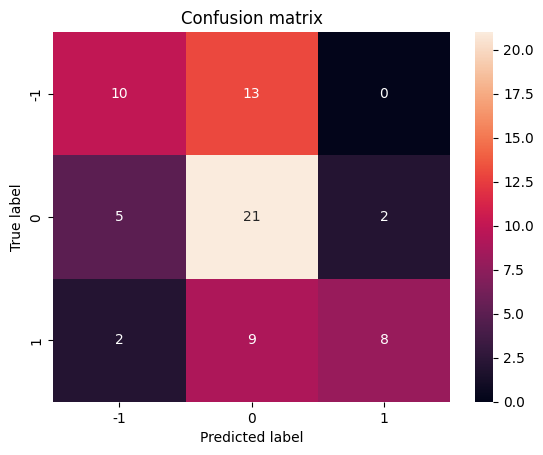

In [8]:
pipeline = Pipeline(
    [
        (
            "model",
            RandomForestClassifier(
                max_depth=study.best_params["max_depth"],
                max_features=study.best_params["max_features"],
                min_samples_leaf=study.best_params["min_samples_leaf"],
                min_samples_split=study.best_params["min_samples_split"],
                n_estimators=study.best_params["n_estimators"],
                random_state=42,
                n_jobs=-1,
            ),
        ),
    ]
)

# считаем метрики на кросс валидации
metric, _ = calc_metrics(
    embeddings,
    y,
    pipeline,
    name="Sentence transformer",
    plot=True,
    calc_jobs=-1,
)

In [9]:
metric

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
Sentence transformer,0.557143,0.547758,0.535278,0.625536,0.722766,0.728567


Такая же модель использующая только первые 512 токенов, показала качетсво значительно выше. Возможно причина в том, что самая важная информация находится в начале пресс-релиза, а добавление остального текста вносит только шум.